# Example 2: Ball drop

To illustrate how to use `calibrator` class, we will continue with [Example 1](http://localhost:8888/notebooks/Desktop/GitHub_Folders/ModCal/examples/Example1/Example1_nb.ipynb#) of a dropping ball. 

First, import the main libraries we use for this example.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt 
from surmise.emulation import emulator
from surmise.calibration import calibrator

We collect the data at two different heights, that are 25 and 50.

In [2]:
x = np.array([[ 0.1, 25. ],
              [ 0.2, 25. ],
              [ 0.3, 25. ],
              [ 0.4, 25. ],
              [ 0.5, 25. ],
              [ 0.6, 25. ],
              [ 0.7, 25. ],
              [ 0.9, 25. ],
              [ 1.1, 25. ],
              [ 1.3, 25. ],
              [ 2.0, 25. ],
              [ 2.4, 25. ],
              [ 0.1, 50. ],
              [ 0.2, 50. ],
              [ 0.3, 50. ],
              [ 0.4, 50. ],
              [ 0.5, 50. ],
              [ 0.6, 50. ],
              [ 0.7, 50. ],
              [ 0.8, 50. ],
              [ 0.9, 50. ],
              [ 1.0, 50. ],
              [ 1.2, 50. ],
              [ 2.6, 50. ],
              [ 2.9, 50. ],
              [ 3.1, 50. ],
              [ 3.3, 50. ],
              [ 3.5, 50. ],
              [ 3.7, 50. ],]).astype('object')
xv = x.astype('float')

In [3]:
def balldroptrue(x):
    def logcosh(x):
        # preventing crashing
        s = np.sign(x) * x
        p = np.exp(-2 * s)
        return s + np.log1p(p) - np.log(2)
    t = x[:, 0]
    h0 = x[:, 1]
    vter = 20
    g = 9.81
    y = h0 - (vter ** 2) / g * logcosh(g * t / vter)
    return y

In [4]:
# variance for the observations in 'y' below
obsvar = 4*np.ones(x.shape[0])  

#observations at each row of 'x'
y = balldroptrue(xv)

print(np.shape(y))

x[x[:,1] == 25, 1] = 'lowdrop'
x[x[:,1] == 50, 1] = 'highdrop'

(29,)


## Model emulation

Recall the computer model experiments and the prior distributions from [Example 1](http://localhost:8888/notebooks/Desktop/GitHub_Folders/ModCal/examples/Example1/Example1_nb.ipynb#).

In [5]:
def balldropmodel_linear(x, theta):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1] + theta[k, 0]
        vter = theta[k, 1]
        f[k, :] = h0 - vter * t
    return f.T

def balldropmodel_grav(x, theta):
    f = np.zeros((theta.shape[0], x.shape[0]))
    for k in range(0, theta.shape[0]):
        t = x[:, 0]
        h0 = x[:, 1]
        g = theta[k]
        f[k, :] = h0 - (g / 2) * (t ** 2)
    return f.T

class priorphys_lin:
    def lpdf(theta):
        return (sps.norm.logpdf(theta[:, 0], 0, 5) +  # initial height deviation
                              sps.gamma.logpdf(theta[:, 1], 2, 0, 10)).reshape((len(theta), 1))  # terminal velocity

    def rnd(n):
        return np.vstack((sps.norm.rvs(0, 5, size=n),  # initial height deviation
                          sps.gamma.rvs(2, 0, 10, size=n))).T  # terminal velocity
        
class priorphys_grav:
    def lpdf(theta):
        return (sps.gamma.logpdf(theta[:, 0], 2, 0, 5)).reshape((len(theta), 1))  # gravity

    def rnd(n):
        return np.reshape(sps.gamma.rvs(2, 0, 5, size=n), (-1,1))  # gravity

Build an emulator using `PCGPwM` to predict the computer model output:

In [6]:
 # the time vector of interest
tvec = np.concatenate((np.arange(0.1, 4.3, 0.1), np.arange(0.1, 4.3, 0.1))) 

# the drop heights vector of interest
hvec = np.concatenate((25 * np.ones(42), 50 * np.ones(42)))  

# the input of interest
xtot = (np.round(np.vstack((tvec, hvec)).T,3)).astype('object')
xtotv = xtot.astype('float')
xtot[xtot[:,1] == 25, 1] = 'lowdrop'
xtot[xtot[:,1] == 50, 1] = 'highdrop'

# draw 50 random parameters from the prior
theta_lin = priorphys_lin.rnd(50) 

# draw 50 random parameters from the prior
theta_grav = priorphys_grav.rnd(50)  

# create a computer experiment to build an emulator for the linear simulation
f_lin = balldropmodel_linear(xv, theta_lin)

# create a computer experiment to build an emulator for the gravity simulation
f_grav = balldropmodel_grav(xv, theta_grav)  

# build an emulator for the linear simulation
emu_lin = emulator(x=x, theta=theta_lin, f=f_lin, method='PCGPwM') 

# build an emulator for the gravity simulation
emu_grav = emulator(x=x, theta=theta_grav, f=f_grav, method='PCGPwM')  

PCGPwM considering  2 PCs
PCGPwM considering  1 PCs


## Model calibration

In [7]:
def plot_theta(cal, whichtheta):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    cal_theta = cal.theta.rnd(1000) 
    axs[0].plot(cal_theta[:, whichtheta])
    axs[1].boxplot(cal_theta[:, whichtheta])
    axs[2].hist(cal_theta[:, whichtheta])
    plt.show()
    
def plot_preds(cal, axs):
    # getting a prediction object   
    post = cal.predict(x)
    rndm_m = post.rnd(s = 1000)
    for k in (25,50):
        inds = np.where(xv[:,1] == k)[0]
        upper = np.percentile(rndm_m[:, inds], 97.5, axis = 0)
        lower = np.percentile(rndm_m[:, inds], 2.5, axis = 0)
        #axs.plot(xv[inds,0], balldroptrue(xv[inds,:]), 'k--',linewidth=2)
        axs.fill_between(xv[inds,0], lower, upper, color = 'grey', alpha=0.25)
        axs.plot(xv[inds, 0], y[inds], 'ro', markersize = 5, color='red')
    return(axs)

### Calibrators for Model 1

In [8]:
# build calibrators for the gravity simulation
cal_grav_1 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav,
                        method='directbayeswoodbury',
                        yvar=obsvar)

In [9]:
cal_grav_2 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav, 
                        method='directbayes',
                        yvar=obsvar, 
                        args={'theta0': np.array([[9]]), 
                              'numsamp': 1000, 
                              'stepType': 'normal', 
                              'stepParam': np.array([1])})

In [10]:
cal_grav_3 = calibrator(emu=emu_grav,
                        y=y,
                        x=x,
                        thetaprior=priorphys_grav, 
                        method='directbayes',
                        yvar=obsvar, 
                        args={'sampler': 'LMC',
                              'theta0': priorphys_grav.rnd(1000)}) 

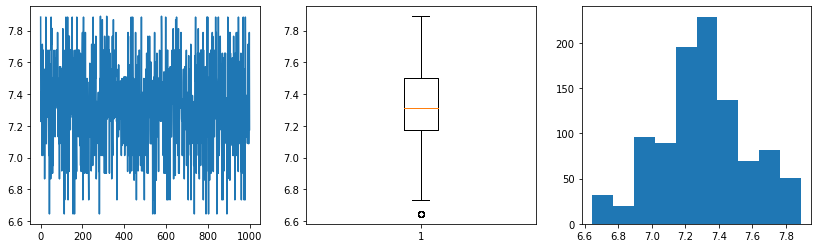

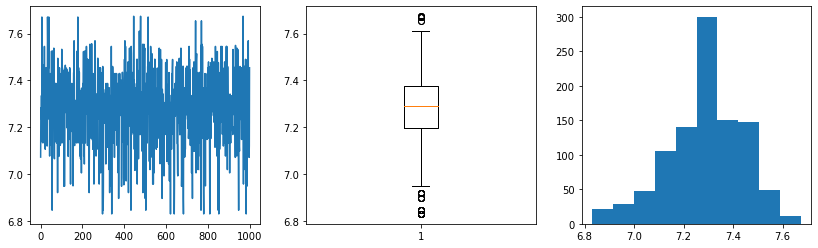

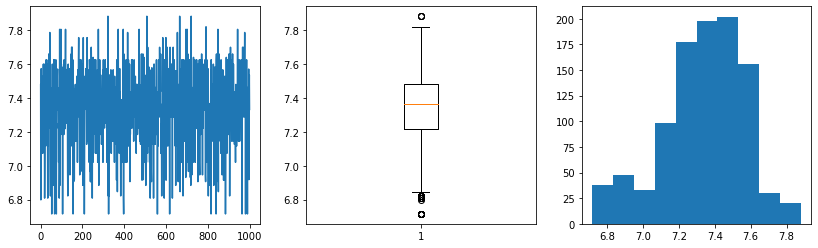

In [11]:
plot_theta(cal_grav_1, 0)
plot_theta(cal_grav_2, 0)
plot_theta(cal_grav_3, 0)

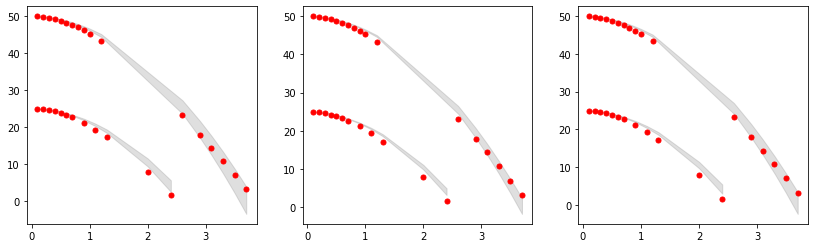

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0] = plot_preds(cal_grav_1, axs[0])
axs[1] = plot_preds(cal_grav_2, axs[1])
axs[2] = plot_preds(cal_grav_3, axs[2])
plt.show()

### Calibrators for Model 2

In [13]:
cal_lin_1 = calibrator(emu=emu_lin,
                       y=y, 
                       x=x,
                       thetaprior=priorphys_lin, 
                       method='directbayeswoodbury', 
                       yvar=obsvar)

In [14]:
cal_lin_2 = calibrator(emu=emu_lin,
                       y=y,
                       x=x,
                       thetaprior=priorphys_lin, 
                       method='directbayes',
                       yvar=obsvar, 
                       args={'theta0': np.array([[0, 9]]), 
                             'numsamp': 1000, 
                             'stepType': 'normal', 
                             'stepParam': np.array([0.1, 1])})

Now, we build a calibrator using a different sampler `LMC`--Langevin Monte Carlo.

In [15]:
cal_lin_3 = calibrator(emu=emu_lin,
                       y=y,
                       x=x,
                       thetaprior=priorphys_lin, 
                       method='directbayes',
                       yvar=obsvar, 
                       args={'sampler': 'LMC',
                             'theta0': priorphys_lin.rnd(1000)})  

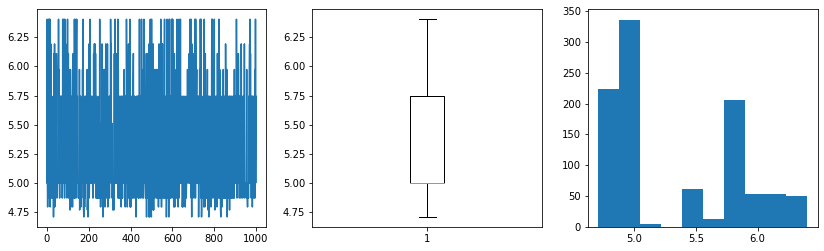

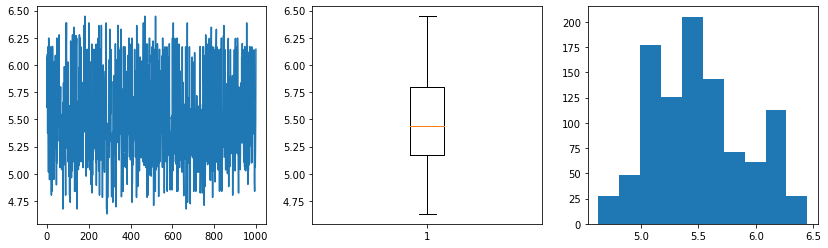

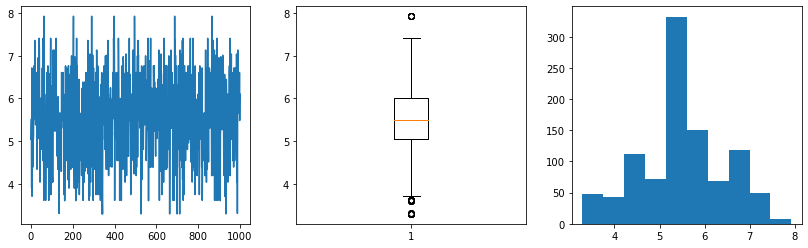

In [16]:
# visualize posterior draws for the calibration parameter
plot_theta(cal_lin_1, 0)
plot_theta(cal_lin_2, 0)
plot_theta(cal_lin_3, 0)

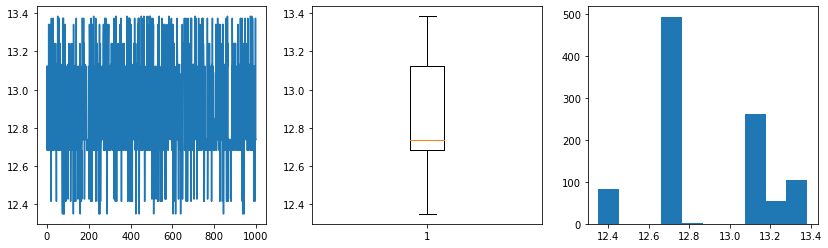

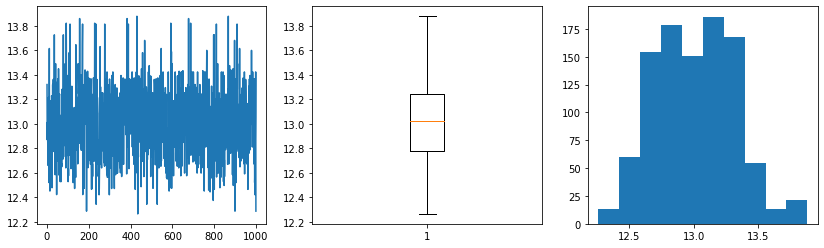

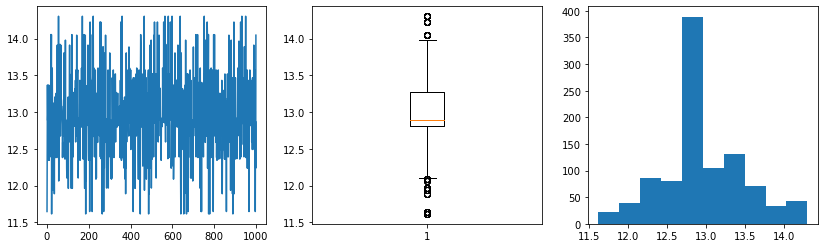

In [17]:
# visualize posterior draws for the calibration parameter
plot_theta(cal_lin_1, 1)
plot_theta(cal_lin_2, 1)
plot_theta(cal_lin_3, 1)

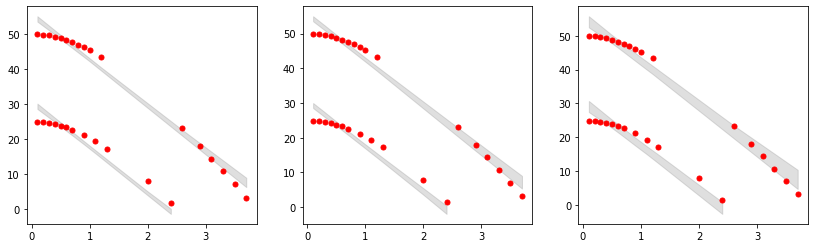

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0] = plot_preds(cal_lin_1, axs[0])
axs[1] = plot_preds(cal_lin_2, axs[1])
axs[2] = plot_preds(cal_lin_3, axs[2])
plt.show()